# 图像增广



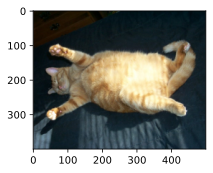

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

左右翻转图像

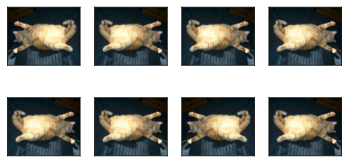

In [3]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

上下翻转图像

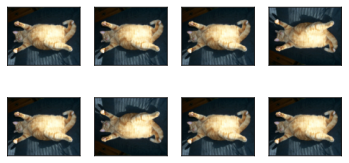

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())

随机裁剪

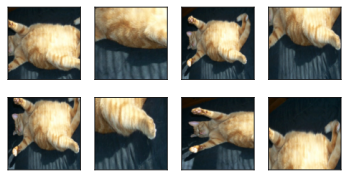

In [3]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

随机更改图像的亮度

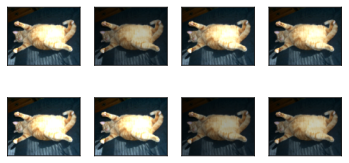

In [6]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

随机更改图像的色调

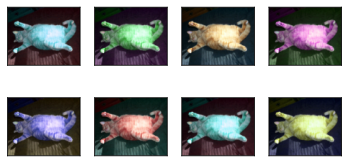

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）

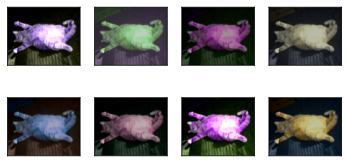

In [4]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

结合多种图像增广方法

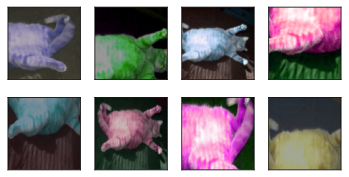

In [9]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

使用图像增广进行训练

100%|██████████| 170498071/170498071 [00:19<00:00, 8690379.25it/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data


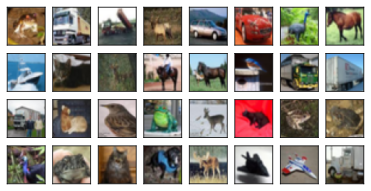

In [10]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

只使用最简单的随机左右翻转

In [5]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

定义一个辅助函数，以便于读取图像和应用图像增广

In [5]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

定义一个函数，使用多GPU对模型进行训练和评估

In [6]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

定义`train_with_data_aug`函数，使用图像增广来训练模型

In [8]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

/usr/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


训练模型

loss 0.195, train acc 0.933, test acc 0.831
1702.6 examples/sec on [device(type='cuda', index=0)]


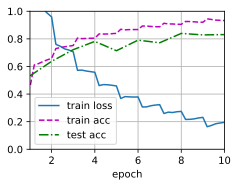

In [15]:
train_with_data_aug(train_augs, test_augs, net)

## 练习

1. 在不使用图像增广的情况下训练模型：train_with_data_aug(no_aug, no_aug)。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过拟合的论点吗？为什么？

In [9]:
import time

loss 0.095, train acc 0.966, test acc 0.812
1729.0 examples/sec on [device(type='cuda', index=0)]
CPU times: user 5min 19s, sys: 7.07 s, total: 5min 26s
Wall time: 5min 21s


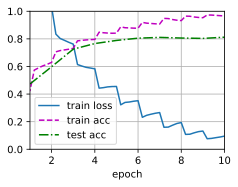

In [18]:
%%time
net = d2l.resnet18(10, 3)
net.apply(init_weights)
train_with_data_aug(test_augs, test_augs, net)

结果：不使用图像增广，训练准确率增加，但测试准确率减小。

结论：支持图像增广可以减轻过拟合的论点。

2. 在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？

In [2]:
import time
import torch
from torch import nn
import torchvision
from d2l import torch as d2l

In [11]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (32, 32), scale=(0.1, 1), ratio=(0.5, 2))
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

devices = d2l.try_all_gpus()

def train_with_data_aug(train_augs, test_augs, net, batch_size=256, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [4]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     color_aug, shape_aug,
     torchvision.transforms.ToTensor()])

net = d2l.resnet18(10, 3)
net.apply(init_weights);

/usr/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 1.083, train acc 0.621, test acc 0.694
1726.2 examples/sec on [device(type='cuda', index=0)]
CPU times: user 5min 12s, sys: 7.77 s, total: 5min 20s
Wall time: 5min 23s


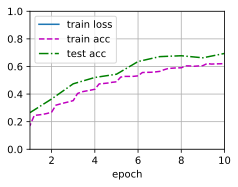

In [7]:
%%time
train_with_data_aug(train_augs, test_augs, net, batch_size=256)

loss 0.856, train acc 0.702, test acc 0.809
1731.1 examples/sec on [device(type='cuda', index=0)]
CPU times: user 5min 11s, sys: 7.6 s, total: 5min 19s
Wall time: 5min 21s


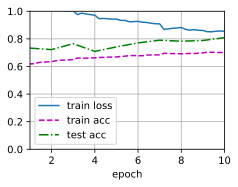

In [8]:
%%time
train_with_data_aug(train_augs, test_augs, net, batch_size=256)

In [12]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     color_aug,
     torchvision.transforms.ToTensor()])

net = d2l.resnet18(10, 3)
net.apply(init_weights);

loss 0.297, train acc 0.896, test acc 0.833
1751.0 examples/sec on [device(type='cuda', index=0)]
CPU times: user 5min 8s, sys: 7.41 s, total: 5min 15s
Wall time: 5min 17s


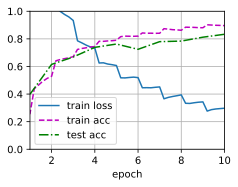

In [13]:
%%time
train_with_data_aug(train_augs, test_augs, net)

结论：

- 增加颜色变换会减小过拟合，稍微增加准确率
- 增加裁剪不会过拟合（测试准确率 > 训练准确率），但是会严重减慢训练速度